In [2]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
from ipywidgets import interact 
import seaborn as sns
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import numpy as np

In [3]:
torch.__version__

'2.1.0'

# Loading Data

In [8]:
dataset = load_dataset('financial_phrasebank', 'sentences_allagree')
data = dataset['train']


In [9]:
df = pd.DataFrame(data)


In [16]:
train_df,test_df = df.iloc[:500], df.iloc[499:1300]

In [17]:
from sklearn.model_selection import train_test_split
initial_labeled_set, pool = train_test_split(df, test_size=0.95, stratify=df['label'])

In [18]:
initial_labeled_set

,sentence,label
491,Cablevision Systems Corp. CVC Their Madison Sq...,1
2233,"In the building and home improvement trade , n...",0
380,"Due to rapid expansion , the market share of T...",2
1794,The move will be carried out by transferring H...,1
2092,"Earlier today , Geberit 's Finnish rival Upono...",0
...,...,...
1118,"Together with Latvia , Cramo will operate 54 r...",1
510,The address location is provided to a local co...,1
1541,Their names have not yet been released .,1
810,The refining margin for the year was $ 13.39 -...,2


# Spliting Data into train_encodings, test_encodings

In [19]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [21]:
train_encodings = tokenizer(initial_labeled_set['sentence'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['sentence'].to_list(), truncation=True, padding=True)
train_labels = initial_labeled_set.label.to_list()
test_labels = test_df.label.to_list()

In [22]:
num_labels = 3
label_to_id = { 'negative' : 0 , 'neutral' : 1 ,'postive' : 2 } 



id_to_label = {value : key for key, value in label_to_id.items()} 

In [23]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3, id2label = id_to_label, label2id = label_to_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TrainingArguments, Dataloader, Metrics are needed to construct this Fine-tune the model

In [24]:
training_args = TrainingArguments(
    output_dir='./BERTModel2',
    do_train=True,
    do_eval=True,
    num_train_epochs=7,  # Reduced number of epochs.
    per_device_train_batch_size=10,  # Reduced batch size for training.
    per_device_eval_batch_size=35,  # Reduced batch size for evaluation.
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    #fp16=True,  # Enable mixed precision training.
)

In [25]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)

In [26]:
def compute_metrics(pred):
    
    ''' 
    Compute Metrics

    This function computes various classification metrics based on the model's predictions and true labels, 
    including accuracy, F1 score, precision, and recall.

    Args:
        pred: A prediction object containing the true labels and predicted probabilities.

    Returns:
        metrics (dict): A dictionary containing the computed metrics:
            - 'Accuracy': The accuracy of the model's predictions.
            - 'F1': The macro F1 score.
            - 'Precision': The macro precision score.
            - 'Recall': The macro recall score.'''


    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Calling our Dataloader

In [27]:
train_dataloader = DataLoader(train_encodings,train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [28]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

#  Evaluate the prediction accuracy of our model on the dataset without training or fine-tuning it

In [29]:
predictions = trainer.predict(test_dataloader)


  0%|          | 0/23 [00:00<?, ?it/s]

In [30]:
predicted_labels = predictions.predictions.argmax(axis=1)


In [31]:
probabilities = tf.nn.softmax(predictions.predictions[0] )


In [32]:
probabilities

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.46746293, 0.339556  , 0.19298114], dtype=float32)>

## An Active Learning Approach Based On Uncertain Sampling

In [33]:
initial_labeled_set.head() # so we fine_tune with the inital_labeled data

,sentence,label
491,Cablevision Systems Corp. CVC Their Madison Sq...,1
2233,"In the building and home improvement trade , n...",0
380,"Due to rapid expansion , the market share of T...",2
1794,The move will be carried out by transferring H...,1
2092,"Earlier today , Geberit 's Finnish rival Upono...",0


In [34]:
initial_labeled_set.shape

(113, 2)

# 

In [35]:
def entropy_for_each_row(class_probabilities):
    """ Calculate entropy for each row in the array """
    return -tf.reduce_sum(class_probabilities * tf.math.log(class_probabilities),axis=1)

In [42]:
def predict_and_calculate_entropy(data):
    
    ''' 
    Predict and Calculate Entropy
    
    This function makes predictions using a pre-trained BERT model, calculates the entropy (uncertainty) of these predictions, 
    and creates a DataFrame containing relevant information.
    
    Args:
        data (DataFrame): A Pandas DataFrame containing text data and associated labels. The DataFrame should have 
        columns 'text' for text data and 'coarse_label' for labels.

    Returns:
        final_df (DataFrame): A Pandas DataFrame containing the following columns:
            - 'text': The original text data.
            - 'predicted_Label': The predicted class labels based on the model's predictions.
            - 'predicted_Probability': The maximum predicted probability for each instance.
            - 'Entropy': The calculated entropy (uncertainty) for each instance.
            - 'coarse_label': The original coarse labels from the input data. ''' 

    
            
    # Sample the Data 
    data_encodings = tokenizer(data['sentence'].to_list(), truncation=True, padding=True)
    dataloader = DataLoader(data_encodings, data.label.to_list())

    # Make predictions with class_probabilities and calculate entropy (uncertainty) 
    predictions = trainer.predict(dataloader)
    prediction_probabilities = tf.constant(predictions.predictions)

    # Predicted Labels 
    predicted_labels = predictions.predictions.argmax(axis=1)

    
    # Prediction probabilities, returning the highest probability for each instance
    prediction_probabilities_max = np.amax(prediction_probabilities, axis=1)

    # Calculate entropy for each instance
    entropies = entropy_for_each_row(tf.nn.softmax(prediction_probabilities))

    entropy_df = pd.DataFrame(
        {'sentence' : data['sentence'].to_list(),
         'predicted_Label': predicted_labels,
         'predicted_Probability': prediction_probabilities_max,
         'Entropy': entropies},
        index=data.index
    )

    final_df = pd.concat([data['label'], entropy_df], axis=1)

    return final_df.sort_values(by=['Entropy'],ascending=False)


# Simulated Active Learning

In [43]:
initial_labeled_set = test_df

In [44]:
initial_labeled_set

,sentence,label
499,"Headquartered in this city , the company is ne...",1
500,"In 2009 , Lee & Man had a combined annual prod...",1
501,In the method the smelt spouts 2 are separated...,1
502,It is necessary to strengthen the company 's o...,1
503,Le Lay succeeds Walter G++nter and will be bas...,1
...,...,...
1295,"May 29 , 2010 ( CompaniesandMarkets.com delive...",1
1296,"Meanwhile , Alfa owns 25.1 % of MegaFon throug...",1
1297,Mercator will use the software for its logisti...,1
1298,Microsoft last week also issued the first patc...,1


In [46]:
hundreds_rows_pred = predict_and_calculate_entropy(initial_labeled_set)

  0%|          | 0/23 [00:00<?, ?it/s]

In [47]:
hundreds_rows_pred

,label,sentence,predicted_Label,predicted_Probability,Entropy
766,1,The Moscow Metro ( www.mosmetro.ru ) was the f...,0,0.049913,1.098519
1131,1,"` Sanoma is a buyer not a target , ' he said .",0,0.169883,1.094366
792,1,The Stena Poseidon is a so-called Panamax tank...,0,0.154018,1.091912
826,2,It also said its third quarter diluted EPS cam...,0,0.327573,1.085276
1246,1,"In 2006 , 452 million tonnes CO2 of EUA ( EU A...",0,0.388059,1.082229
...,...,...,...,...,...
1057,1,The company website is www.ahlstrom.com .,0,0.724103,1.023085
1127,1,Yvonne Jones is owner of Chameleon Interiors .,0,0.716056,1.022434
592,1,"She will succeed Krister Kylas , who has decid...",0,0.749421,1.022069
515,1,"The inventors are Bylander Johan , Ponten Fred...",0,0.752964,1.021625


# Active Learning

In [3]:
# Initialize empty lists to store metrics for each iteration
accuracy_list = []
precision_list = []
recall_list = []
loss_list = []
x_labels = []
n = 0

for iteration in range(15):
    n += 10
    #print(n)
    #print(hundreds_rows_pred[0:n])
    initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:n]['sentence'].to_list(), truncation=True, padding=True)
    initial_labeled_labels = hundreds_rows_pred[0:n].label.to_list()
    initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)

   
    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= initial_labeled_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )

    trainer.train()  


    #hundreds_rows_pred = predict_and_calculate_entropy(hundreds_rows_pred)


    metrics = trainer.evaluate()

    print('eval_Accuracy :',metrics['eval_Accuracy'])

    accuracy_list.append(metrics['eval_Accuracy'])
    precision_list.append(metrics['eval_Precision'])
    recall_list.append(metrics['eval_Recall'])
    loss_list.append(metrics['eval_loss'])
    x_labels.append(n)



"# Initialize empty lists to store metrics for each iteration\naccuracy_list = []\nprecision_list = []\nrecall_list = []\nloss_list = []\nx_labels = []\nn = 0\n\nfor iteration in range(15):\n    n += 10\n    #print(n)\n    #print(hundreds_rows_pred[0:n])\n    initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:n]['sentence'].to_list(), truncation=True, padding=True)\n    initial_labeled_labels = hundreds_rows_pred[0:n].label.to_list()\n    initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)\n\n   \n    trainer = Trainer(\n        #the pre-trained bert model that will be fine-tuned\n        model=model,\n        #training arguments that we defined above\n        args=training_args,\n        train_dataset= initial_labeled_dataloader,\n        eval_dataset = test_dataloader,\n        compute_metrics= compute_metrics\n    )\n\n    trainer.train()  \n\n\n    #hundreds_rows_pred = predict_and_calculate_entropy(hundreds_rows_pred)\n\n\n    metrics = 

In [65]:
prediction = trainer.predict(test_dataloader)

  0%|          | 0/23 [00:00<?, ?it/s]

In [69]:
bert_pred_df = pd.DataFrame({'Bert_Pred' : prediction.label_ids, 'Label' : test_df['label'].to_list() }) 

bert_pred_df.to_csv('finance_label_Bert_Pred.csv',index=False)

In [60]:
test_df

,sentence,label
499,"Headquartered in this city , the company is ne...",1
500,"In 2009 , Lee & Man had a combined annual prod...",1
501,In the method the smelt spouts 2 are separated...,1
502,It is necessary to strengthen the company 's o...,1
503,Le Lay succeeds Walter G++nter and will be bas...,1
...,...,...
1295,"May 29 , 2010 ( CompaniesandMarkets.com delive...",1
1296,"Meanwhile , Alfa owns 25.1 % of MegaFon throug...",1
1297,Mercator will use the software for its logisti...,1
1298,Microsoft last week also issued the first patc...,1


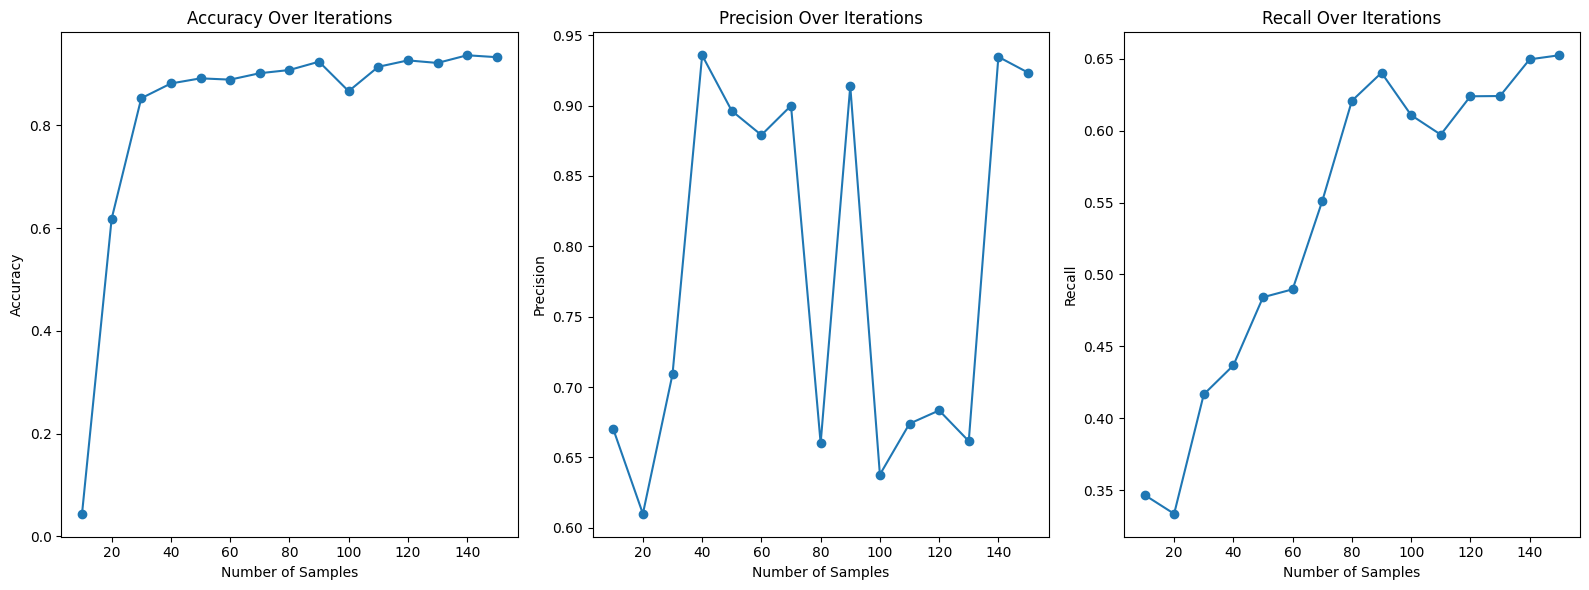

In [51]:
# Plot the metrics
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(x_labels, accuracy_list, marker='o')
plt.title('Accuracy Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(x_labels, precision_list, marker='o')
plt.title('Precision Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(x_labels, recall_list, marker='o')
plt.title('Recall Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [52]:
predictions = trainer.predict(test_dataloader)
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(test_df['label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))


  0%|          | 0/23 [00:00<?, ?it/s]

accuracy 93.0% 


In [53]:
from sklearn.metrics import confusion_matrix


# Confusion Matrix

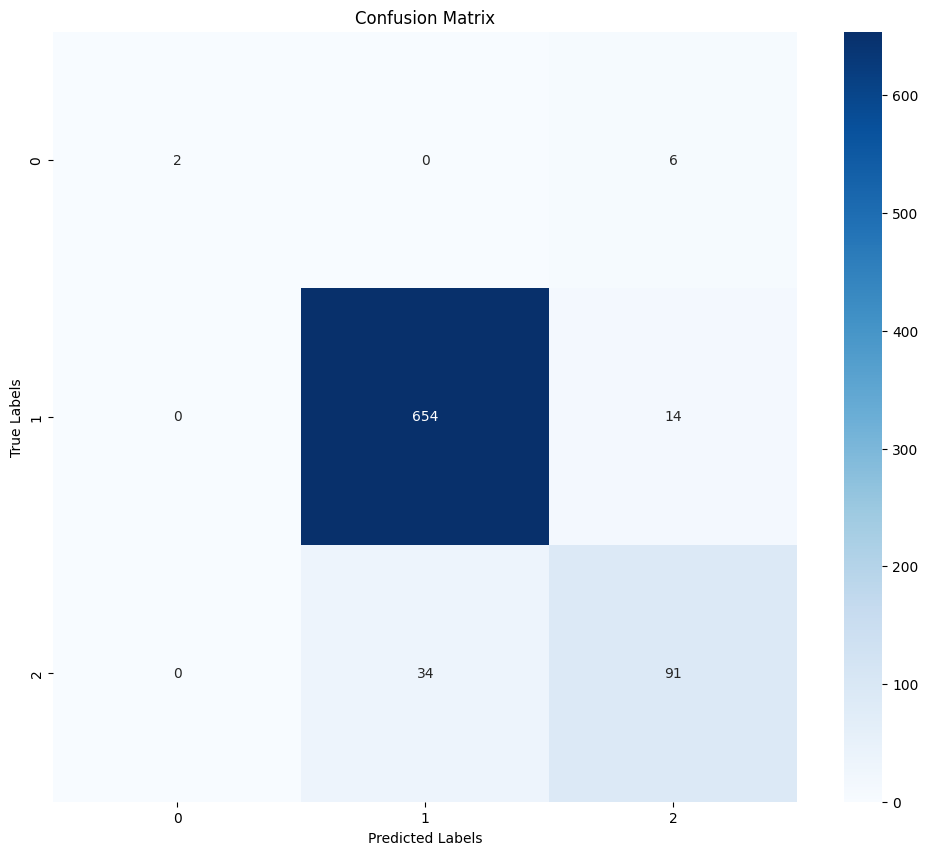

In [54]:
# Compute the confusion matrix
cm = confusion_matrix(test_df['label'].to_list(),predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the confusion matrix as an image
plt.savefig('CM.png')
plt.show()

In [55]:
predictions = trainer.predict(train_dataloader)

  0%|          | 0/4 [00:00<?, ?it/s]

In [70]:
import csv


# Combine the lists into a list of tuples
data = list(zip(x_labels, accuracy_list, precision_list, recall_list, loss_list))

# Specify the file name
csv_file_name = "finance_label_ACC.csv"

# Write the data to a CSV file
with open(csv_file_name, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    csv_writer.writerow(['Labels', 'accuracy', 'precision', 'recall', 'loss'])
    
    # Write the data
    csv_writer.writerows(data)

print(f"CSV file '{csv_file_name}' has been created.")


CSV file 'finance_label_ACC.csv' has been created.
